In [63]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.metrics import *
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from CONSTANTS import *
from audioread.ffdec import ReadTimeoutError
from functions import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

# Load all possible Data

In [64]:
start = datetime.now()
end = datetime.strptime('01/01/2008', '%m/%d/%Y')
df, coin = prices(COIN, start=end, end=start)
df.sort_values('time', ascending=False, inplace=True)

Incorporate FGI metrics

In [65]:
fgi = get_fgi_data(df)
df = pd.merge(df, fgi, left_on='time', right_on='timestamp', how='left')
df['timestamp'].fillna(pd.to_datetime('1970-01-01'), inplace=True)
val = df[df['value'].isna() == False]['value'].values[0] # Last known FGI value
fgiClassification = df[df['value_classification'].isna() == False]['value_classification'].values[0] # Last known FGI classification
df['value'].fillna(val, inplace=True)
df['value_classification'].fillna(fgiClassification, inplace=True)

## Crypto market collector

# Steps to train LSTM to predict buy and sell



1.   Obtain additional metrics

* Moving averages (short-term and long-term)
* Relative Strength Index (RSI)
* Moving Average Convergence Divergence (MACD)
* Bollinger Bands
* Volume indicators

2.   Model Approaches

* Classification
  * label buys, sells, holds (1, -1, 0) based on market data
  * predict each label

* Regression
  * predict return over time
    * look at windows of time to find optimal profits
  * identify buy and sell periods



### Generate Metrics

In [66]:
# Short-term SMA (20 periods) and long-term SMA (50 periods)
df['SMA_20'] = df['close'].rolling(window=20).mean().fillna(method='bfill')
df['SMA_50'] = df['close'].rolling(window=50).mean().fillna(method='bfill')

# Exponential Moving Averages (optional, can be used in place of or along with SMAs)
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean().fillna(method='bfill')
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean().fillna(method='bfill')
df['RSI'] = compute_rsi(df['close'], window=14)

# Calculate the 12-period and 26-period EMA of the closing price
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# Bollinger Bands
df['BB_Middle'] = df['SMA_20']  # Middle band is the 20-period SMA
df['BB_STD'] = df['close'].rolling(window=20).std().fillna(method='bfill')
df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_STD']
df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_STD']
df['Volume_MA_20'] = df['volume'].rolling(window=20).mean()

# Daily Return and On-Balance Volume (OBV)
df['daily_return'] = df['close'].pct_change()
df['direction'] = np.where(df['daily_return'] > 0, 1, -1)
df.loc[df['daily_return'].isna(), 'direction'] = 0
df['OBV'] = (df['volume'] * df['direction']).fillna(0).cumsum()
df.drop(columns=['daily_return', 'direction'], inplace=True)

### Plot the Bollinger Bands

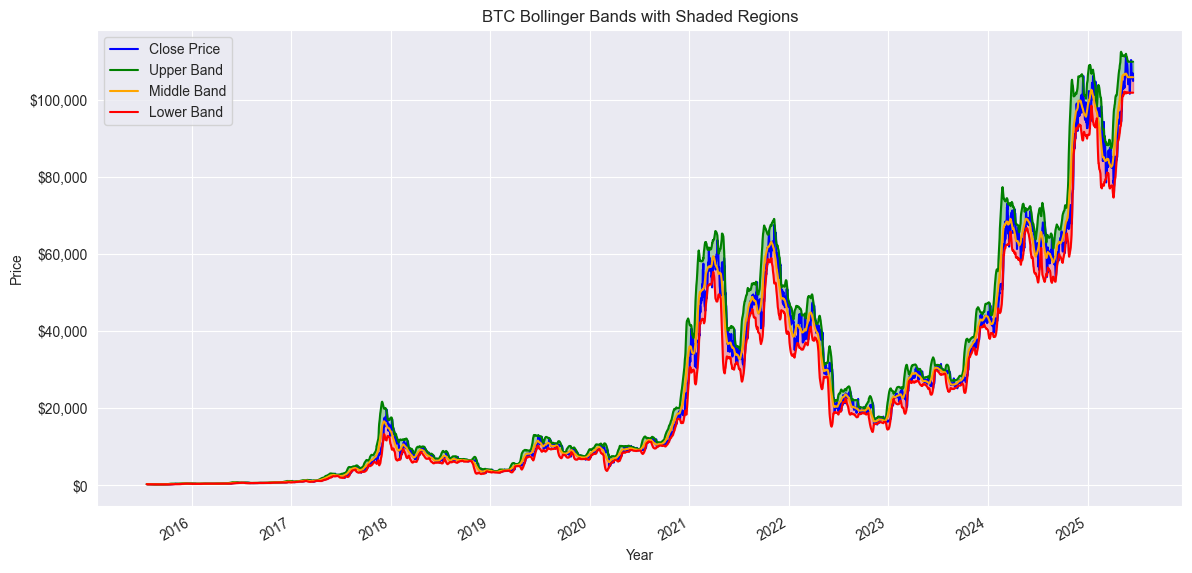

In [67]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the price and Bollinger Bands
ax.plot(df['time'], df['close'], label='Close Price', color='blue')
ax.plot(df['time'], df['BB_Upper'], label='Upper Band', color='green')
ax.plot(df['time'], df['BB_Middle'], label='Middle Band', color='orange')
ax.plot(df['time'], df['BB_Lower'], label='Lower Band', color='red')
ax.fill_between(df['time'], df['BB_Upper'], df['BB_Middle'], color='green', alpha=0.3)
ax.fill_between(df['time'], df['BB_Middle'], df['BB_Lower'], color='red', alpha=0.3)

ax.set_xlabel('Year')
ax.set_ylabel('Price')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.set_title(f'{COIN} Bollinger Bands with Shaded Regions')
ax.legend()
ax.grid(True)

fig.autofmt_xdate()
if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig(f'plots/{COIN}_Bollinger_Bands.png')
try:
    df.set_index(df['time'], inplace=True, drop=True)
    df.drop('time', axis=1, inplace=True)
except:
    pass
df.to_csv(fullDataPath(coin), index=True)